fitting ...
  |======================================================================| 100%


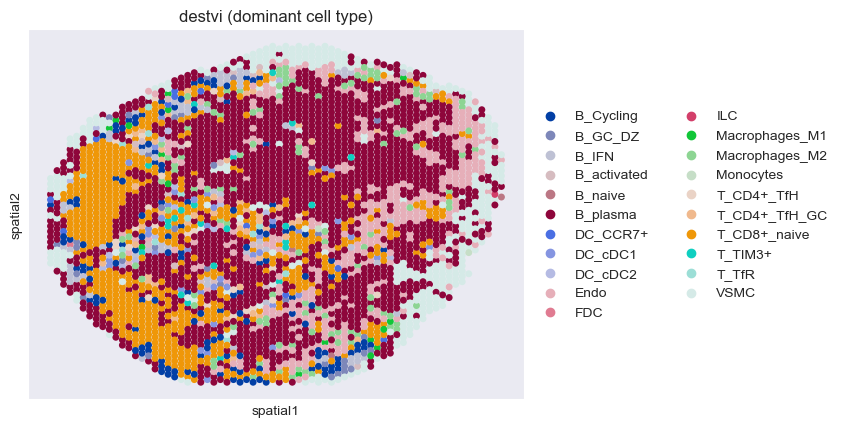

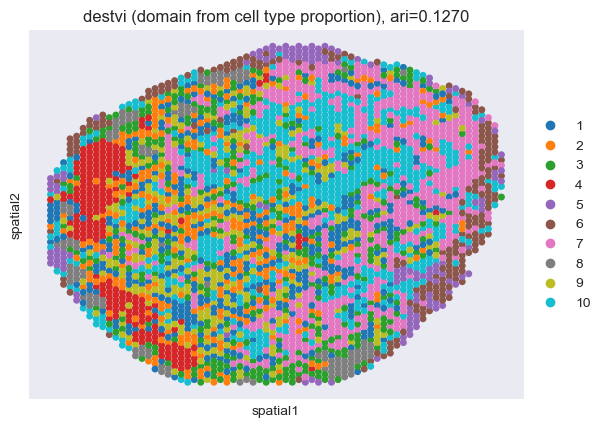

In [28]:
from sklearn.metrics import adjusted_rand_score
from SpatialGlue.utils import clustering
import numpy as np
import pandas
import scanpy as sc
import matplotlib.pyplot as plt

adata_post = sc.read_h5ad('Dataset/human_lymph_node/adata_destvi.h5ad')
predicted_proportion = adata_post.obsm['proportion'].iloc[:, list(np.where(adata_post.obsm['proportion'].std(0) > 1e-5)[0])]
adata_post.obs['destvi_ct'] = predicted_proportion.idxmax(axis=1)
adata_post.obsm['destvi_ct'] = predicted_proportion.values

clustering(adata_post, key='destvi_ct', add_key='destvi_ct_domain', n_clusters=10, method='mclust', use_pca=True)
ari_ct = adjusted_rand_score(adata_post.obs['cluster'], adata_post.obs['destvi_ct_domain'])

# sc.pl.embedding(adata_post, basis='spatial', color='cell2location_ct', title='cell2location (dominant cell type)', show=False,
#                 s=100)
# plt.savefig('preliminary_results/cell2location_ct.pdf', bbox_inches="tight")
# sc.pl.embedding(adata_post, basis='spatial', color='cell2location_ct_domain',
#                 title='cell2location (domain from cell type proportion), ari=%.4f' % ari_ct, show=False, s=100)
# plt.savefig('preliminary_results/cell2location_domain.pdf', bbox_inches="tight")
sc.pl.embedding(adata_post, basis='spatial', color='destvi_ct', title='destvi (dominant cell type)', show=True, s=100)
sc.pl.embedding(adata_post, basis='spatial', color='destvi_ct_domain',
                title='destvi (domain from cell type proportion), ari=%.4f' % ari_ct, show=True, s=100)

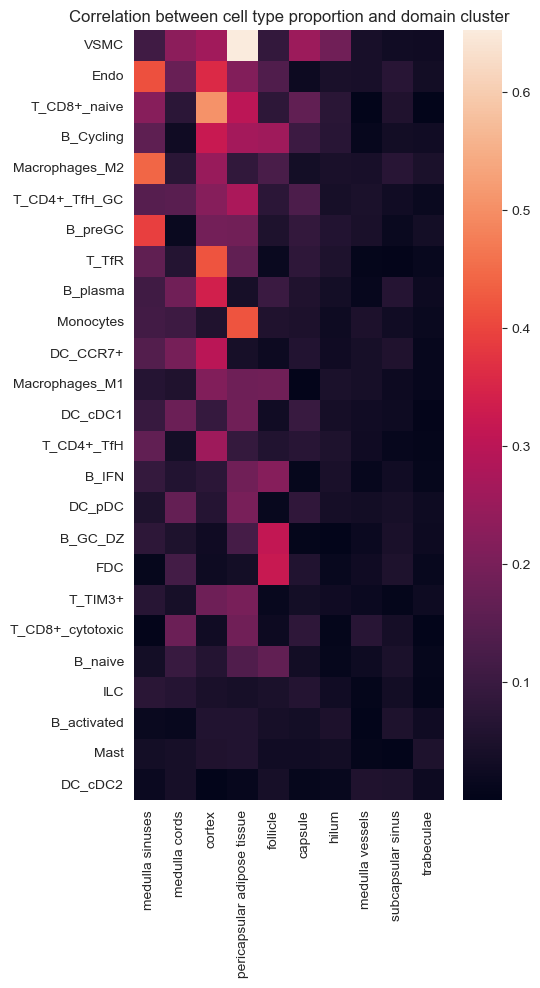

In [29]:
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt
import seaborn as sns

cmap = pandas.DataFrame(columns=adata_post.obs['cluster'].unique(), index=predicted_proportion.columns, dtype='float')
for ct in cmap.index:
    for domain in cmap.columns:
        cmap.loc[ct, domain] = abs(pointbiserialr(adata_post.obs['cluster'] == domain, predicted_proportion[ct]).correlation)
cmap = cmap.loc[cmap.sum(1).sort_values(ascending=False).index]
plt.subplots(figsize=(5, 10))
sns.heatmap(cmap).set_title('Correlation between cell type proportion and domain cluster')
plt.savefig('preliminary_results/heatmap_ct_cluster_destvi.pdf', bbox_inches="tight")

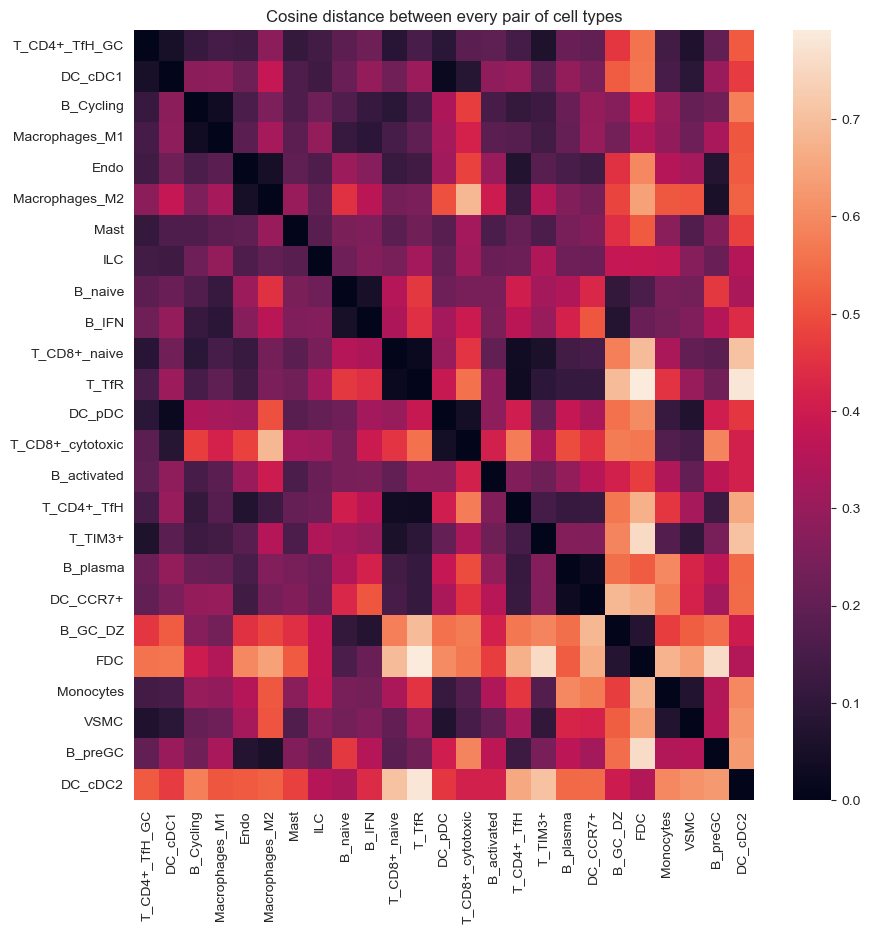

In [37]:
from scipy.spatial.distance import cosine

ct_distance = pandas.DataFrame(columns=cmap.index, index=cmap.index, dtype=float)
for ct1 in ct_distance.index:
    for ct2 in ct_distance.columns:
        ct_distance.loc[ct1, ct2] = cosine(cmap.loc[ct1].values, cmap.loc[ct2].values)
ct_list = []
ct_distance_copy = ct_distance.copy()
threshold = .1
ct_dict = {}
i = 0
while True:
    ct = ct_distance_copy.columns[ct_distance_copy.sum(1).argmin()]
    ct_list.append(ct)
    ct_corr = ct_distance_copy.sort_values(by=[ct]).loc[:, ct][ct_distance.sort_values(by=[ct]).loc[:, ct] < threshold][
              1:min((ct_distance.sort_values(by=[ct]).loc[:, ct] < threshold).sum(), 2)].index.tolist()
    ct_corr = ct_distance_copy.loc[ct_corr].sum(1).sort_values().index.tolist()
    ct_list += ct_corr
    ct_distance_copy = ct_distance_copy.drop(columns=[ct] + ct_corr, index=[ct] + ct_corr)
    ct_dict[i] = [ct] + ct_corr
    i += 1
    if len(ct_list) == ct_distance.shape[0]:
        break
ct_distance = ct_distance.loc[ct_list, ct_list]
plt.subplots(figsize=(10, 10))
sns.heatmap(ct_distance).set_title('Cosine distance between every pair of cell types')
plt.savefig('preliminary_results/heatmap_ct_distance_destvi.pdf', bbox_inches="tight")

fitting ...
  |======================================================================| 100%


<Axes: title={'center': 'destvi (domain from cell type proportion), ari=0.1330'}, xlabel='spatial1', ylabel='spatial2'>

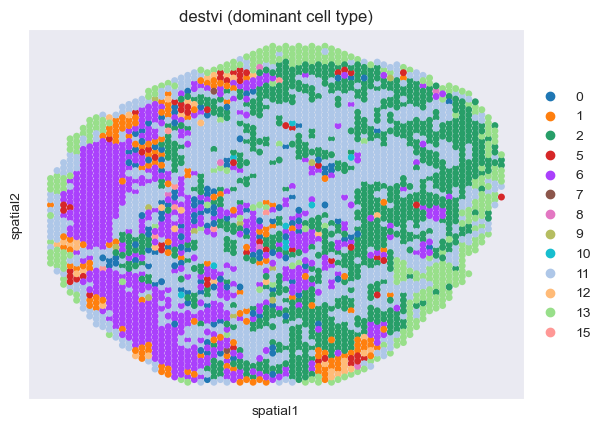

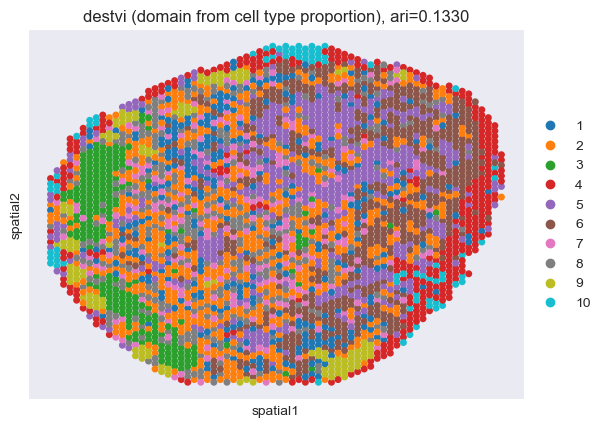

In [39]:
adata_post_copy = adata_post.copy()
for ct in ct_dict.keys():
    adata_post_copy.obs[str(ct)] = predicted_proportion[ct_dict[ct]].sum(1)
adata_post_copy.write_h5ad('Dataset/human_lymph_node_rep1/adata_destvi_combined.h5ad')
adata_post_copy.obs['destvi_combined_ct'] = adata_post_copy.obs.iloc[:, adata_post.obs.shape[1]:].idxmax(axis=1)
sc.pl.embedding(adata_post_copy, basis='spatial', color='destvi_combined_ct', title='destvi (dominant cell type)', show=False, s=100)
# plt.savefig('preliminary_results/cell2location_combined_ct2.pdf', bbox_inches="tight")

adata_post_copy.obsm['destvi_combined_ct'] = adata_post_copy.obs.iloc[:, adata_post.obs.shape[1]:-1].values
clustering(adata_post_copy, key='destvi_combined_ct', add_key='destvi_combined_ct_domain', n_clusters=10,
           method='mclust', use_pca=False)
ari = adjusted_rand_score(adata_post.obs['cluster'], adata_post_copy.obs['destvi_combined_ct_domain'])
sc.pl.embedding(adata_post_copy, basis='spatial', color='destvi_combined_ct_domain',
                title='destvi (domain from cell type proportion), ari=%.4f' % ari, show=False, s=100)
# plt.savefig('preliminary_results/cell2location_combined_domain2.pdf', bbox_inches="tight")